In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import torch

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml
import logging

from lib.helpers.dataloader_helper import build_dataloader
from lib.helpers.model_helper import build_model

In [2]:
mode = 'test' # test, eval, train
config = 'lib/kitti.yaml'


def create_logger(log_file):
    log_format = '%(asctime)s  %(levelname)5s  %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_format, filename=log_file)
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter(log_format))
    logging.getLogger(__name__).addHandler(console)
    return logging.getLogger(__name__)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
os.makedirs(cfg['trainer']['log_dir'], exist_ok=True)
logger = create_logger(os.path.join(cfg['trainer']['log_dir'], 'train.log'))
cfg['dataset']['batch_size'] = 1

import shutil
if mode != 'eval':
    if not mode != 'test':
        if os.path.exists(os.path.join(cfg['trainer']['log_dir'], 'lib/')):
            shutil.rmtree(os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    if not mode != 'test':
        shutil.copytree('./lib', os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    

#  build dataloader
train_loader, val_loader, test_loader = build_dataloader(cfg['dataset'])

# build model
model = build_model(cfg['model'], train_loader.dataset.cls_mean_size)


Using device: cuda

NVIDIA GeForce RTX 3060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
from lib.helpers.print_helper import Printer

# evaluation mode
if mode == 'eval':
    print('evaluation mode')
    printer = Printer(cfg['tester'], cfg['dataset'], model, val_loader, logger)
elif mode == 'test':
    print('test mode')
    printer = Printer(cfg['tester'], cfg['dataset'], model, test_loader, logger)
else:
    print('train mode')
    printer = Printer(cfg['tester'], cfg['dataset'], model, train_loader, logger)

2024-10-01 22:25:23,567   INFO  ==> Loading from checkpoint './checkpoints/model.pth'
/home/akos/Documents/code/MonoLSS/lib/helpers/save_helper.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

test mode


In [4]:
idx = 0

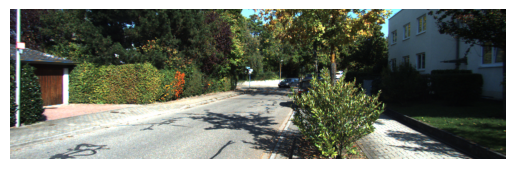

In [5]:
printer.print(idx)
idx = idx + 1